no negative sampling  

NN_word = 200  
num_features = 2

~~(2019.6.2) use_multiprocessing = True~~  
~~約半分の時間になった~~

(2019.6.3) use fit (not fit_generator)

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from feature_eng import lowcols

In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
import random
from collections import defaultdict, Counter
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.sequence import skipgrams
import tensorflow as tf

In [4]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, cmap=cmap, **kwargs)
def scatter(x, y, color, **kwargs):
    plt.scatter(x, y, marker='.')

### create sample data

In [5]:
NN_word = 200
NN_sentence = 10000
NN_SEG = 7

In [6]:
product_list = [ee+1 for ee in range(NN_word)]
user_list = [ee+1 for ee in range(NN_sentence)]

In [7]:
a, _ = divmod(len(user_list), NN_SEG)
a
cls_user = [int(user_id / (a+1)) for user_id in range(1, 1+len(user_list))]

In [8]:
a, _ = divmod(len(product_list), NN_SEG)
print(a)

cls_prod = [int(prod_id / (a+1)) for prod_id in range(1, 1+len(product_list))]

28


In [9]:
random.seed(0)

X_list = []

for ii in range(len(user_list)):
    cls = cls_user[ii]
    product_group = np.array(product_list)[np.array(cls_prod) == cls]
    nword = random.randint(5, 20)
    prods = random.sample(product_group.tolist(), nword)
    irow = np.zeros((1,NN_word))
    irow[0,np.array(prods)-1] = 1
    X_list.append(irow)

X = np.concatenate(X_list)
print(X.shape)
X

(10000, 200)


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [10]:
X_df = pd.DataFrame(X, dtype=int)
X_df.index = ['r'+ee.astype('str') for ee in (np.arange(X_df.shape[0])+1)]
X_df.columns = ['c'+ee.astype('str') for ee in np.arange(X_df.shape[1])+1]
print(X_df.shape)
X_df.head()

(10000, 200)


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c191,c192,c193,c194,c195,c196,c197,c198,c199,c200
r1,0,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
r2,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
r3,1,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
r4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
r5,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_df.values.shape

(10000, 200)

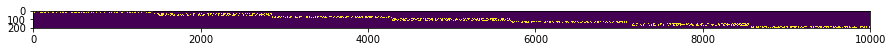

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(X_df.values.T)

In [13]:
wd2v = lowcols.WD2vec(X_df)
wd2v

In [14]:
num_features = 2

models = wd2v.make_model(num_user=X_df.shape[0], num_product=NN_word, num_features=num_features)
models['model_gk1'].summary()
models['model_user'].summary()
print('\n\n##################### model >>>')
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 2)              20000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 200)               401       
Total params: 20,401
Trainable params: 20,401
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_user (InputLayer)      (None, 1)                 0         
_________________________________________________________________
user_e

In [15]:
wd2v.models['model'].get_layer('user_embedding').get_weights()[0].shape

(10000, 2)

(10000, 2)


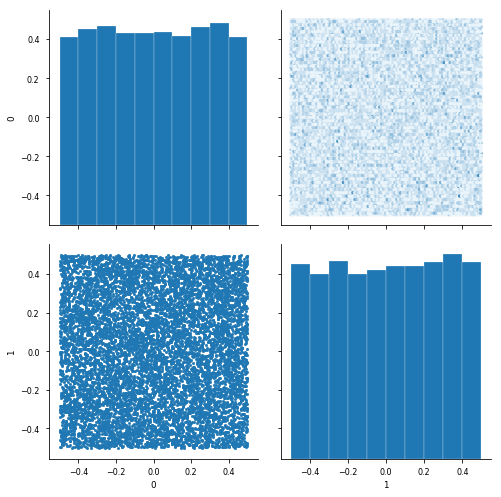

In [16]:
wgt_user = wd2v.get_wgt_byrow()
# wgt_user = model.get_layer('user_embedding').get_weights()[0]
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 2)


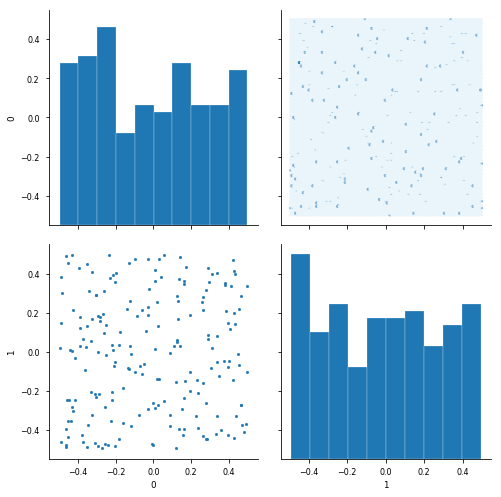

In [17]:
wgt_lm = wd2v.get_wgt_bycol()
print(wgt_lm.shape)
df = pd.DataFrame(wgt_lm[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

### 1

In [18]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 2)


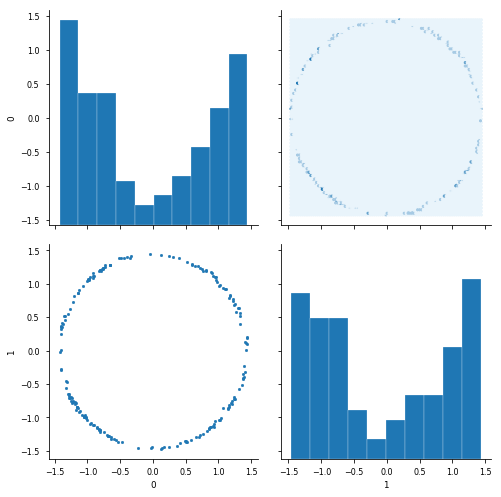

In [19]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 2)


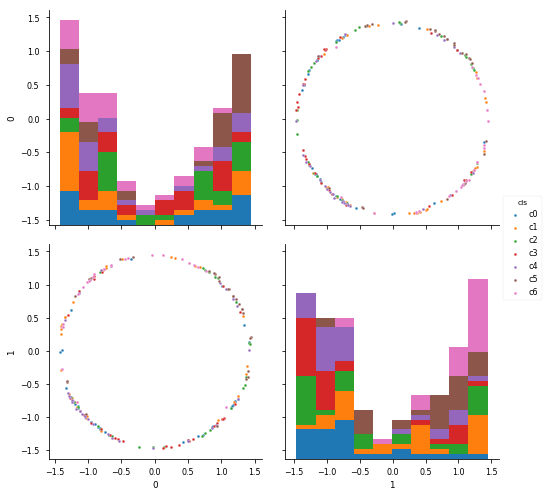

In [20]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 2)


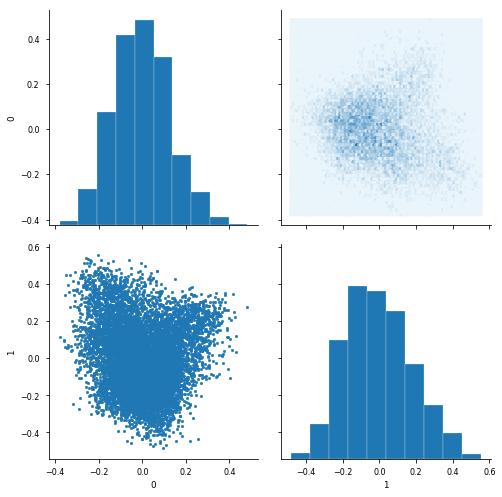

In [21]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 2)


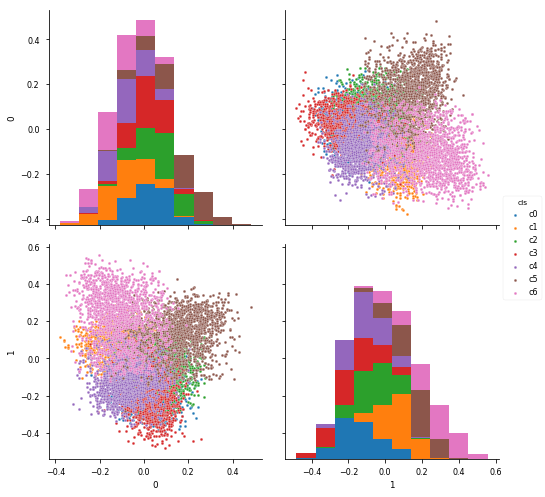

In [22]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [23]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [25]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,-0.277774,1.370678,c0
1,0.914968,1.094166,c0
2,-0.735845,-1.194012,c0
3,-0.882472,1.102505,c0
4,1.099838,-0.919694,c0


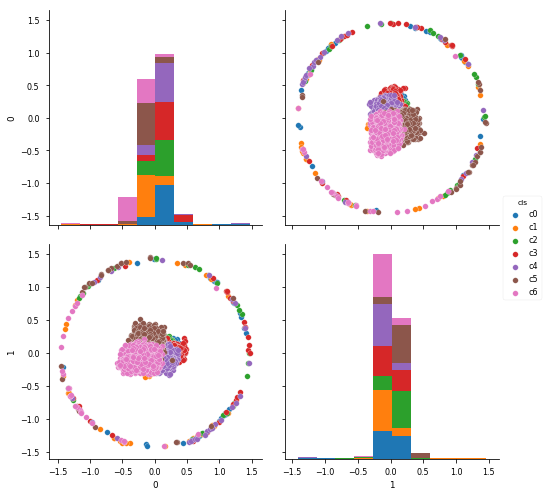

In [26]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [27]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 2)


In [28]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,-3.071152,-7.649821,c0
1,1.244531,-10.432357,c0
2,-15.116568,-22.032764,c0
3,-5.991741,-7.323254,c0
4,-5.239358,-17.546497,c0


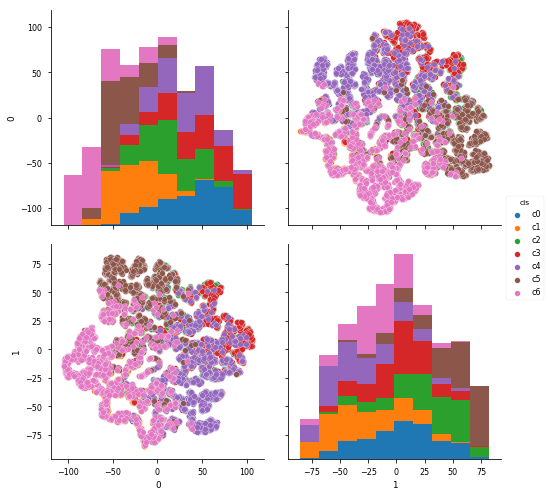

In [29]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 2 (further train)

In [30]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 2)


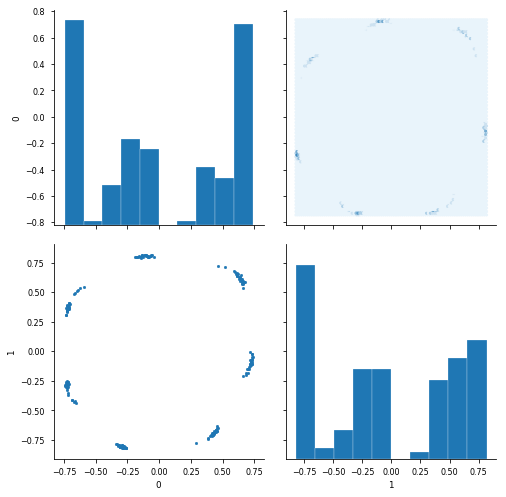

In [31]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 2)


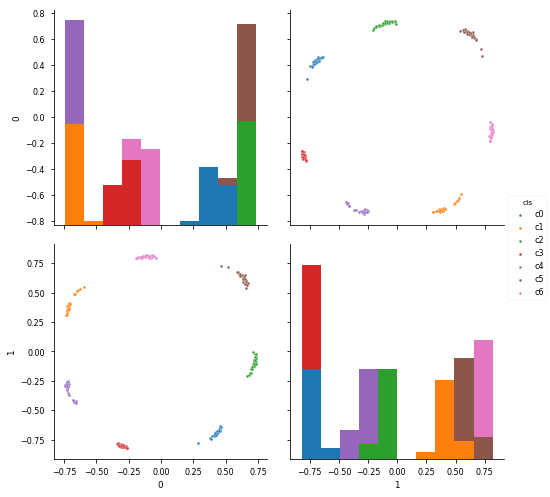

In [32]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 2)


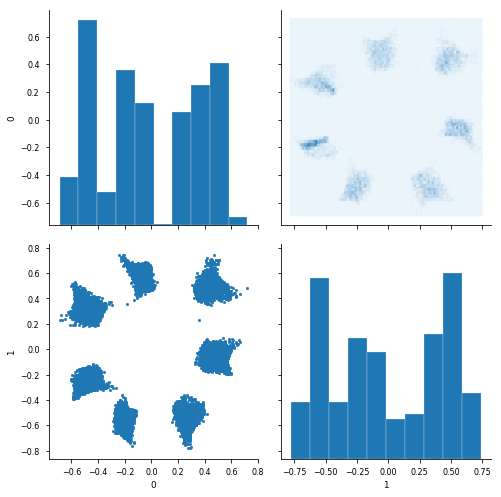

In [33]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 2)


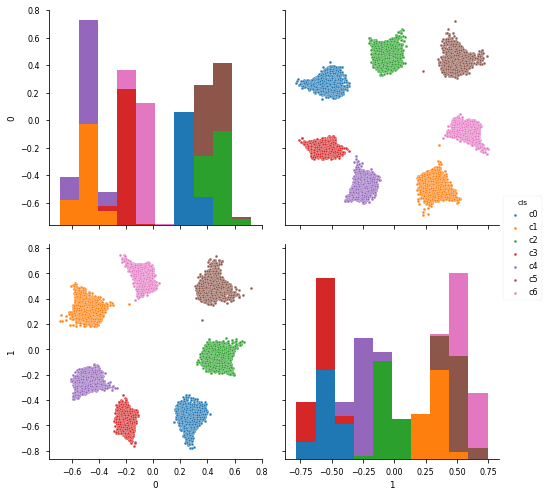

In [34]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [35]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [37]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,0.531304,-0.587605,c0
1,0.553033,-0.584007,c0
2,0.612741,-0.545480,c0
3,0.513869,-0.586076,c0
4,0.581957,-0.565143,c0


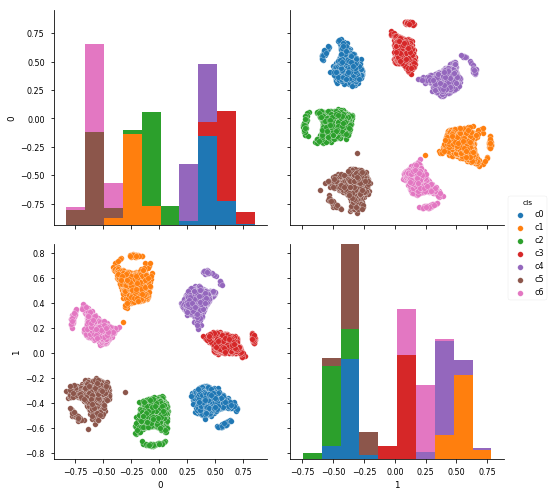

In [38]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [39]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 2)


In [40]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,44.348007,-82.536148,c0
1,44.695824,-82.779205,c0
2,45.311714,-84.141502,c0
3,44.273434,-82.343071,c0
4,45.052326,-83.472458,c0


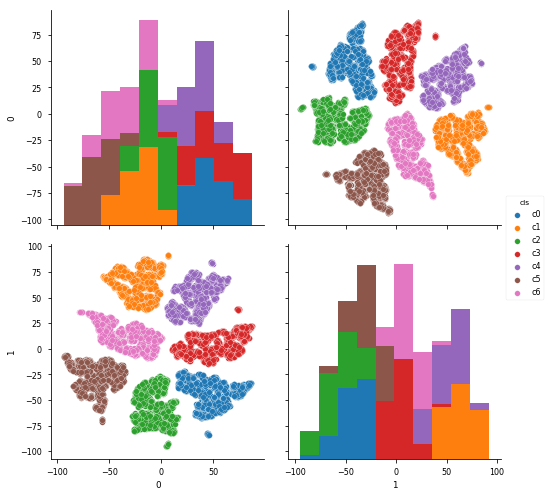

In [41]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

### 3 (further train)

In [42]:
wd2v.train(epochs=30, batch_size=32, verbose=0)

(200, 2)


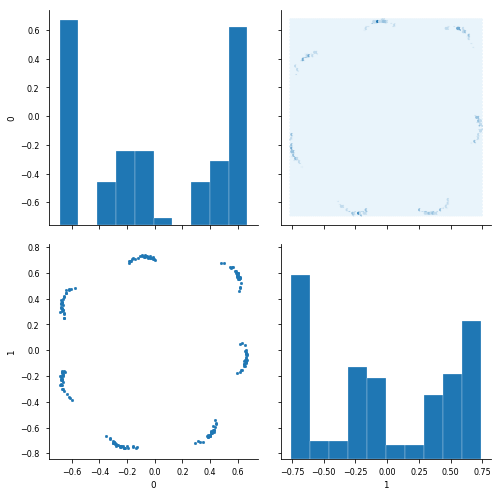

In [43]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(200, 2)


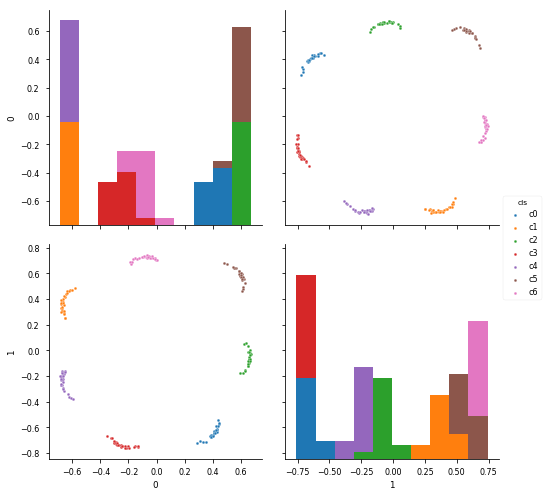

In [44]:
wgt_prod = wd2v.get_wgt_bycol()
print(wgt_prod.shape)
df = pd.DataFrame(wgt_prod[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_prod]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

(10000, 2)


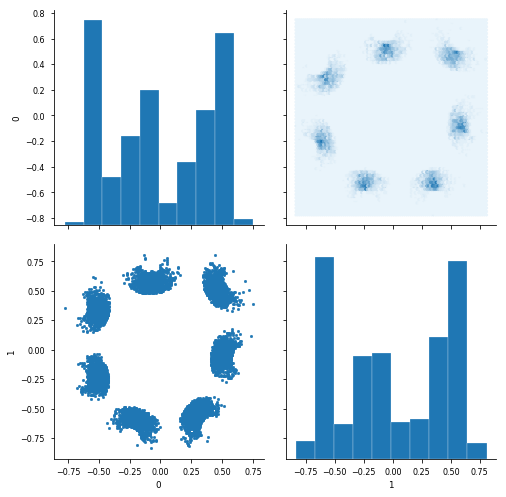

In [45]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
sns.set_context('paper')
g = sns.PairGrid(df, size=3.5)
g.map_diag(plt.hist, edgecolor="w")
g.map_lower(scatter)
g.map_upper(hexbin)

(10000, 2)


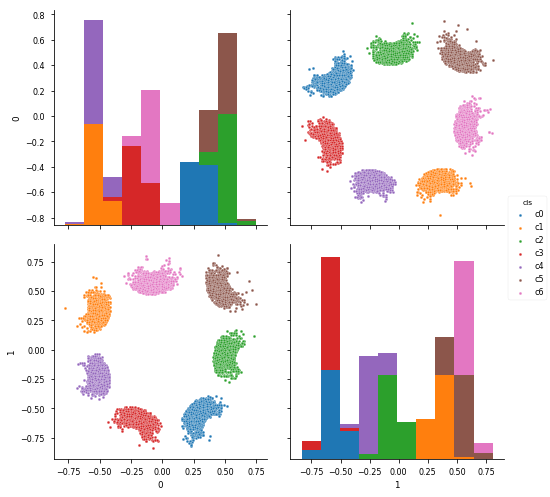

In [46]:
wgt_user = wd2v.get_wgt_byrow()
print(wgt_user.shape)
df = pd.DataFrame(wgt_user[:,:5])
df['cls'] = ['c'+str(ii) for ii in cls_user]
sns.pairplot(df, markers='.', hue='cls', size=3.5)

In [47]:
'''PCA'''
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(np.vstack([wgt_prod, wgt_user]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [48]:
f = pca.transform(np.vstack([wgt_prod, wgt_user]))
f.shape

(10200, 2)

In [49]:
df = pd.DataFrame(f)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,-0.513484,-0.559441,c0
1,-0.574320,-0.528057,c0
2,-0.552585,-0.538471,c0
3,-0.435041,-0.545273,c0
4,-0.533084,-0.539387,c0


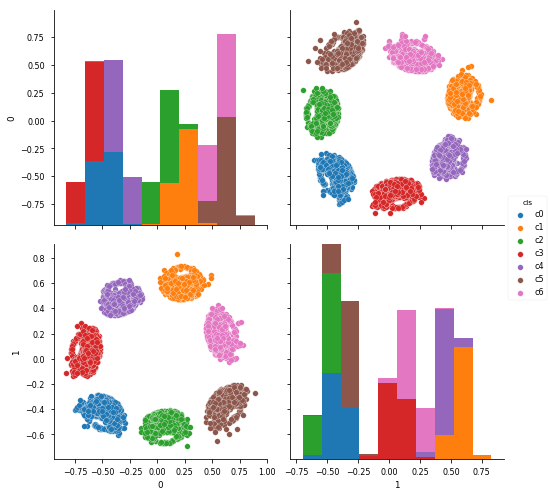

In [50]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')

In [51]:
'''t-SNE'''
from sklearn import manifold
wgt = np.vstack([wgt_prod, wgt_user])
print(wgt.shape)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(wgt)

(10200, 2)


In [52]:
df = pd.DataFrame(X_tsne)
df['cls'] = ['c'+str(ii) for ii in cls_prod] + ['c'+str(ii) for ii in cls_user]
df.head()

,0,1,cls
0,-16.166832,-92.456963,c0
1,-16.340429,-94.253128,c0
2,-16.283611,-93.708954,c0
3,-15.971274,-86.902733,c0
4,-16.236523,-93.212082,c0


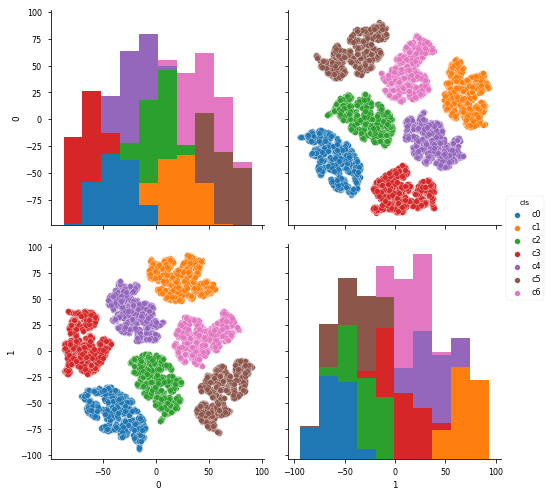

In [53]:
sns.pairplot(df, markers='o', hue='cls', size=3.5, diag_kind='hist')